# CPU Performance Prediction using MLP Neural Network

## Author: Spiros Papadopoulos

### Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

### Read dataset

In [2]:
# Import data from xlsx 
entire_dataset = pd.read_excel('Machine_CPU_Dataset.xlsx',   usecols = "D:J")

In [3]:
entire_dataset.head() # Preview of the first entries

,Machine Cycle Time (ns),Minimum Main Memory (KB),Maximum Main Memory (KB),Cache Memory (KB),Minimum Channels,Maximum Channels,Published Relative Performance
0,26,8000,16000,0,8,16,185
1,50,2000,8000,8,1,5,71
2,810,512,512,8,1,1,18
3,175,256,2000,0,3,24,22
4,300,384,12000,6,1,24,53


In [4]:
entire_dataset.tail() # Preview of last entries

,Machine Cycle Time (ns),Minimum Main Memory (KB),Maximum Main Memory (KB),Cache Memory (KB),Minimum Channels,Maximum Channels,Published Relative Performance
204,225,1000,4000,2,3,6,24
205,160,512,4000,2,1,5,30
206,140,2000,32000,32,1,20,134
207,60,2000,8000,65,1,8,92
208,30,8000,64000,128,12,176,1150


### Visualize data

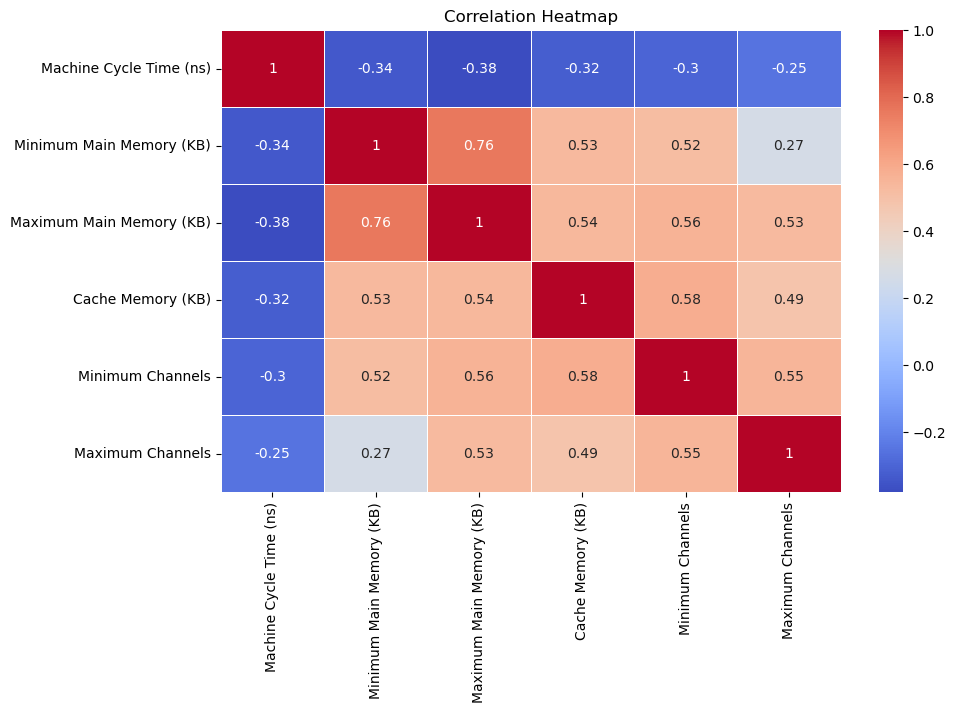

In [5]:
# Separate input features (X) and output (Y)
X = entire_dataset.iloc[:, :-1]  # All columns except the last one (features)
Y = entire_dataset.iloc[:, -1]   # Only the last column (output)

# Heatmap - Showing correlation between characteristics
plt.figure(figsize=(10, 6))
correlation_matrix = X.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

C:\Users\spiro\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


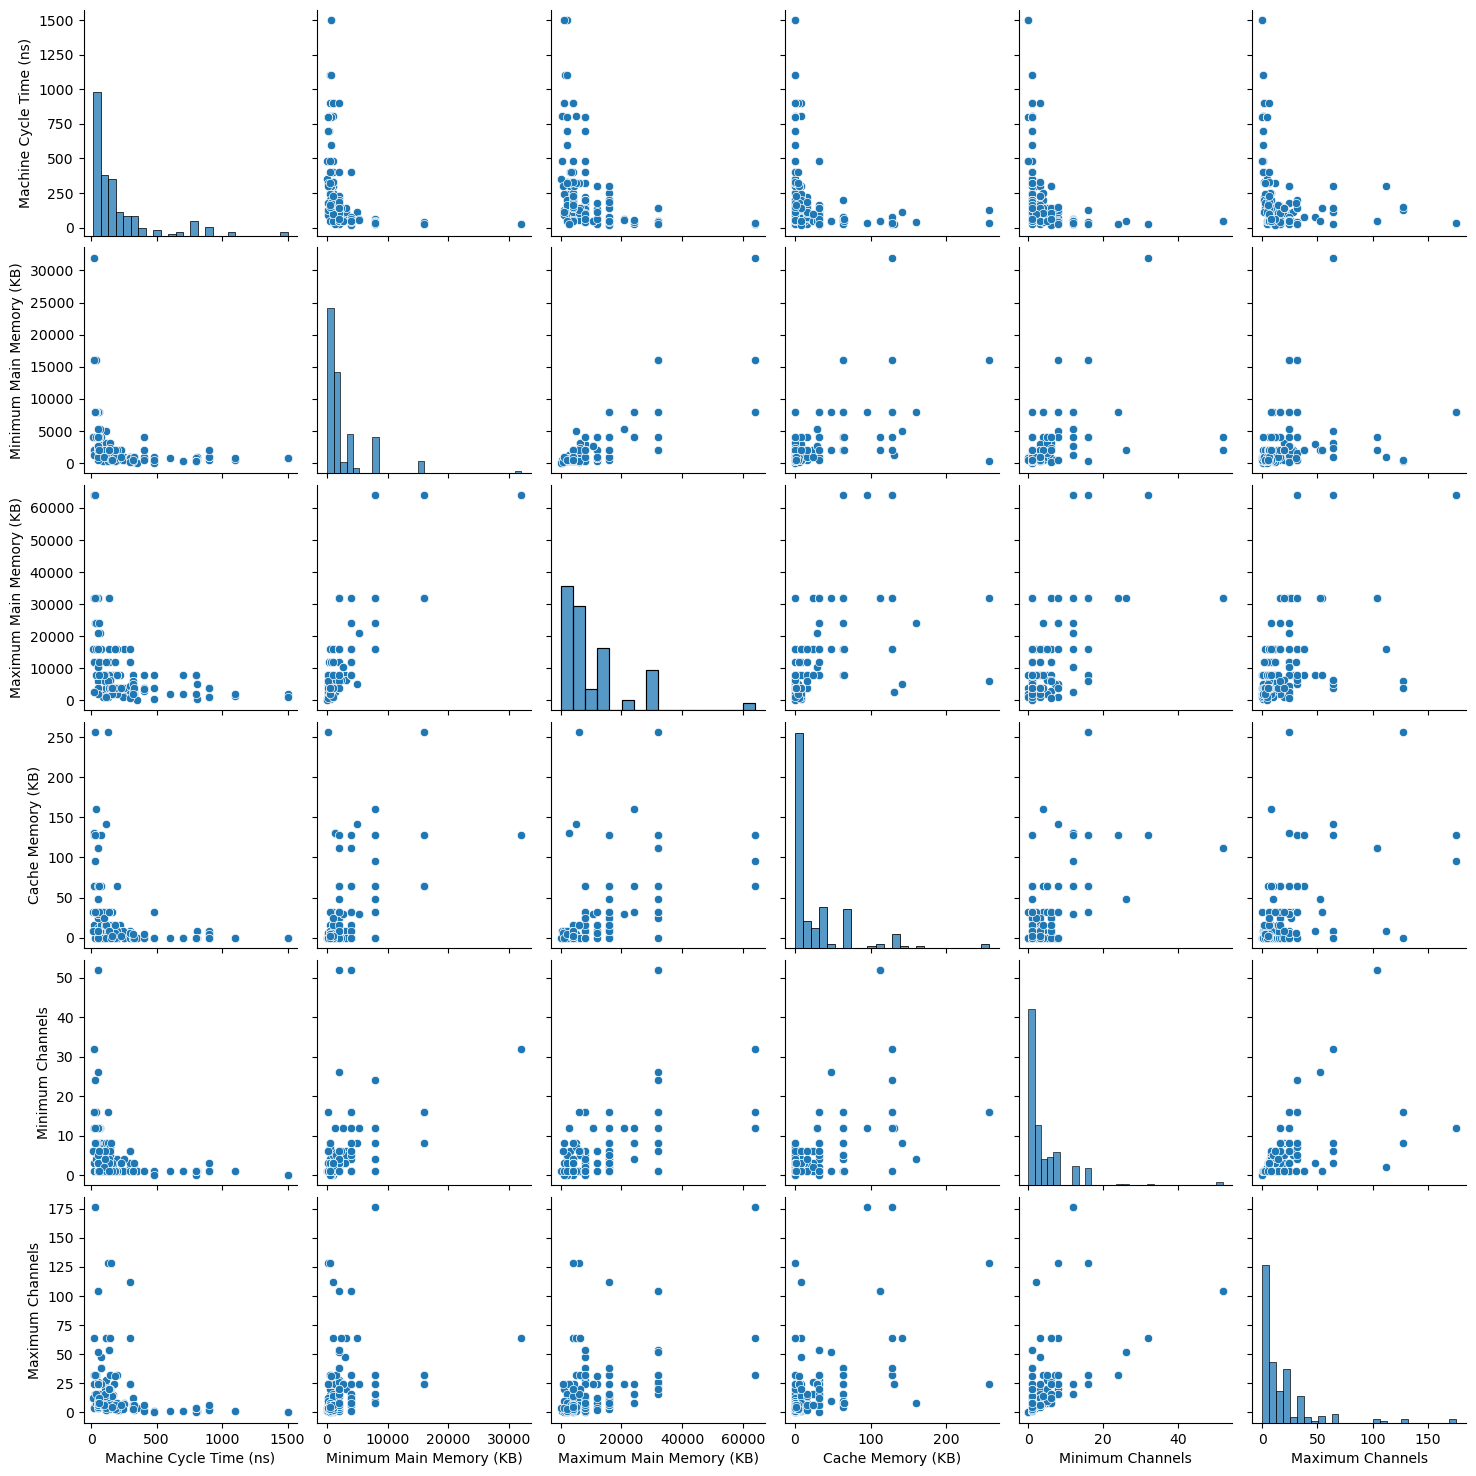

In [6]:
# Pair Plot Example: Visualizing relationships across all input variables
sns.pairplot(X)
plt.show()

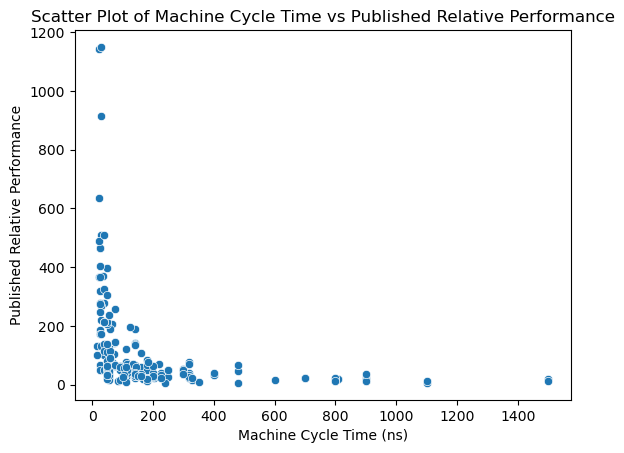

In [7]:
sns.scatterplot(data=entire_dataset, x='Machine Cycle Time (ns)', y='Published Relative Performance')
plt.title('Scatter Plot of Machine Cycle Time vs Published Relative Performance')
plt.show()

### Split data into training, validation, testing sets

In [8]:
# Determine the total number of rows in the dataset
print('Total data available: ' + str(entire_dataset.shape[0]))

# Training set
train_index = 90
X_train, Y_train = X.iloc[:train_index], Y.iloc[:train_index]

# Validation set
val_index = 149
X_val, Y_val = X.iloc[train_index:val_index], Y.iloc[train_index:val_index]

# Testing set
X_test, Y_test = X.iloc[val_index:], Y.iloc[val_index:]

Total data available: 209


### Normalize data for stable training

In [9]:
# See the ranges of each characteristic in the training set
X_train.describe().transpose()[['mean', 'std']]

,mean,std
Machine Cycle Time (ns),216.088889,261.324442
Minimum Main Memory (KB),2587.533333,3071.850770
Maximum Main Memory (KB),11040.911111,10833.410872
Cache Memory (KB),19.011111,29.455544
Minimum Channels,4.133333,6.526007
Maximum Channels,18.466667,26.442305


In [10]:
# Normalize data in [-1 1] range

# Initialize scalers
feature_scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
target_scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))


X_train_sc = pd.DataFrame(feature_scaler.fit_transform(X_train))
X_val_sc = pd.DataFrame(feature_scaler.fit_transform(X_val))
X_test_sc = pd.DataFrame(feature_scaler.fit_transform(X_test))

Y_train_sc = pd.Series(target_scaler.fit_transform(Y_train.values.reshape(-1, 1)).ravel())
Y_val_sc = pd.Series(target_scaler.fit_transform(Y_val.values.reshape(-1, 1)).ravel())
Y_test_sc = pd.Series(target_scaler.fit_transform(Y_test.values.reshape(-1, 1)).ravel())


In [11]:
X_val_sc.describe().transpose()[['min', 'max']] # Ensure that scaling is done properly

,min,max
0,-1.0,1.0
1,-1.0,1.0
2,-1.0,1.0
3,-1.0,1.0
4,-1.0,1.0
5,-1.0,1.0


In [12]:
display(X_val)

,Machine Cycle Time (ns),Minimum Main Memory (KB),Maximum Main Memory (KB),Cache Memory (KB),Minimum Channels,Maximum Channels
90,50,2000,8000,8,3,6
91,75,2000,8000,8,3,24
92,900,1000,1000,0,1,2
93,124,1000,8000,0,1,8
94,72,2000,8000,16,6,8
95,180,2000,8000,8,1,6
96,180,2000,16000,16,1,6
97,38,8000,32000,64,8,24
98,140,1000,16000,16,1,3
99,480,96,512,0,1,1


### Create & Train NN model 

In [13]:
# Create MLP network
def createMLP():
    # Use 2 hidden layers
    model = keras.Sequential(
        [
            keras.Input(shape=(6,)),                                   # 6-dimensional input space (Input Layer)           
            layers.Dense(64, activation = 'relu', name = 'hl1'), # 1st Hidden Layer with 64 neurons
            layers.Dense(64, activation = 'relu', name = 'hl2'), # 2nd Hidden Layer with 64 neurons
            layers.Dense(1)                                      # Output Layer with a single neuron
#             layers.Dropout(0.1)
        ]
    )

    # Use MAE as a loss function and Adam Optimizer
    model.compile(loss = 'mean_squared_error',
                  optimizer = tf.keras.optimizers.Adam(0.001),
                  metrics = ['mae', 'accuracy']
                  )
    
    print (model.summary())
    
    return model

In [14]:
# Create the model
model = createMLP()

# Train the model
history = model.fit(
    X_train_sc,            # Training features
    Y_train_sc,            # Ouputs
    epochs=100,             # Number of epochs
    batch_size=16,         # Batch size
    validation_data=(X_val_sc, Y_val_sc),  # Validation features and labels
)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ hl1 (Dense)                          │ (None, 64)                  │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hl2 (Dense)                          │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,673 (18.25 KB)

 Trainable params: 4,673 (18.25 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.0000e+00 - loss: 1.1485 - mae: 1.0299 - val_accuracy: 0.0000e+00 - val_loss: 0.5117 - val_mae: 0.6700
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0000e+00 - loss: 0.3892 - mae: 0.5822 - val_accuracy: 0.0000e+00 - val_loss: 0.1137 - val_mae: 0.2732
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0000e+00 - loss: 0.0511 - mae: 0.1842 - val_accuracy: 0.0000e+00 - val_loss: 0.0695 - val_mae: 0.1762
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - loss: 0.0632 - mae: 0.2142 - val_accuracy: 0.0000e+00 - val_loss: 0.0839 - val_mae: 0.2228
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - loss: 0.0752 - mae: 0.2344 - val_accuracy: 0.0000e+00 - val_loss: 0.0471 - val_mae: 0.1415
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - loss: 0.0342 - mae: 0.1271 - val_accuracy: 0.0000e+00 - val_loss: 0.0349 - val_mae: 0.1057
Ep

Epoch 43/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0146 - loss: 0.0018 - mae: 0.0321 - val_accuracy: 0.0169 - val_loss: 0.0155 - val_mae: 0.0762
Epoch 44/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0236 - loss: 0.0018 - mae: 0.0310 - val_accuracy: 0.0169 - val_loss: 0.0153 - val_mae: 0.0751
Epoch 45/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0236 - loss: 0.0017 - mae: 0.0310 - val_accuracy: 0.0169 - val_loss: 0.0153 - val_mae: 0.0746
Epoch 46/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0102 - loss: 0.0021 - mae: 0.0345 - val_accuracy: 0.0169 - val_loss: 0.0155 - val_mae: 0.0762
Epoch 47/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0050 - loss: 0.0016 - mae: 0.0303 - val_accuracy: 0.0169 - val_loss: 0.0154 - val_mae: 0.0759
Epoch 48/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0072 - loss: 0.0014 - mae: 0.0292 - val_accuracy: 0.0169 - val_loss: 0.0152 - val_mae: 0.0749
Epoch 49/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - 

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0072 - loss: 0.0017 - mae: 0.0317 - val_accuracy: 0.0169 - val_loss: 0.0150 - val_mae: 0.0743
Epoch 86/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0032 - loss: 0.0012 - mae: 0.0267 - val_accuracy: 0.0169 - val_loss: 0.0150 - val_mae: 0.0742
Epoch 87/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0236 - loss: 0.0016 - mae: 0.0304 - val_accuracy: 0.0169 - val_loss: 0.0151 - val_mae: 0.0748
Epoch 88/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0072 - loss: 0.0015 - mae: 0.0294 - val_accuracy: 0.0169 - val_loss: 0.0149 - val_mae: 0.0742
Epoch 89/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0050 - loss: 0.0014 - mae: 0.0281 - val_accuracy: 0.0169 - val_loss: 0.0150 - val_mae: 0.0745
Epoch 90/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0146 - loss: 0.0016 - mae: 0.0297 - val_accuracy: 0.0169 - val_loss: 0.0151 - val_mae: 0.0748
Epoch 91/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0

### Evaluate the model on the test data

In [15]:
results = model.evaluate(X_test_sc, Y_test_sc, verbose=1)

print(f'Test Loss: {results[0]}')


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0111 - loss: 0.0055 - mae: 0.0510     
Test Loss: 0.0060274978168308735


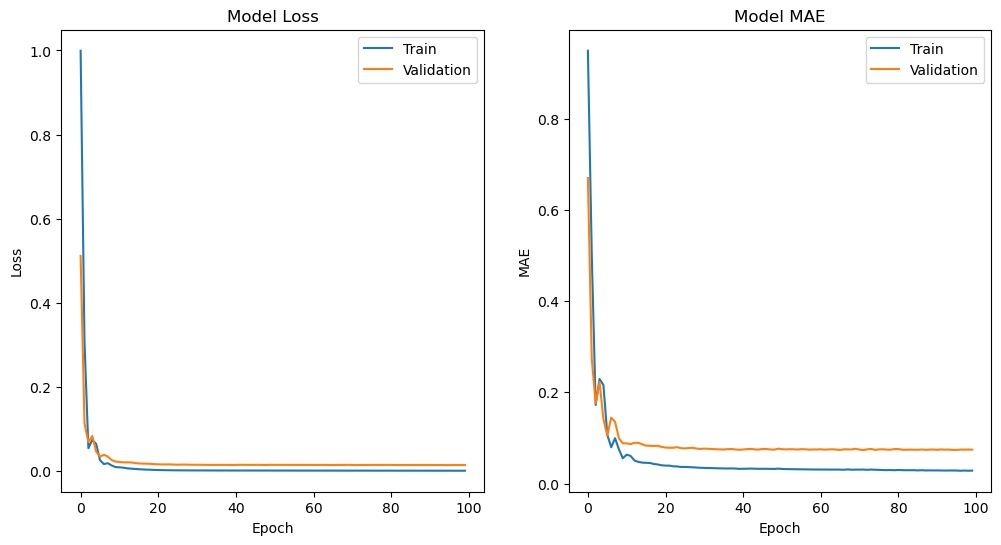

In [16]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

# Plot training & validation metric MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend(['Train', 'Validation'])

plt.show()

In [17]:
# Predict using the test data
Y_test_pred_sc = model.predict(X_test_sc)

Y_test_pred =  target_scaler.inverse_transform(Y_test_pred_sc)

# Example of comparing predictions to actual values
results = pd.DataFrame({
    'True Values': Y_test,
    'Predictions': Y_test_pred.flatten()
})
print(results)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
     True Values  Predictions
149          114   184.572220
150           28    58.215569
151           54   106.980789
152           36    45.189159
153           32    28.598413
154           46   102.392975
155           36    41.653683
156           86   108.176926
157           30    35.040520
158           30    65.483070
159          489   483.030334
160           66   103.659050
161           72    59.511421
162           16    10.507678
163           20    53.673389
164           61    59.115059
165          100   135.518723
166          307   437.002808
167           40    50.094826
168           80    75.459763
169           60    77.655518
170           32    57.101082
171          510   554.386353
172           37    50.357670
173           38    38.650639
174           29    45.462593
175          259   184.129028
176          237   223.814636
177           62    48.113758
178           22    53.673389
179          116   157.509613
18

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


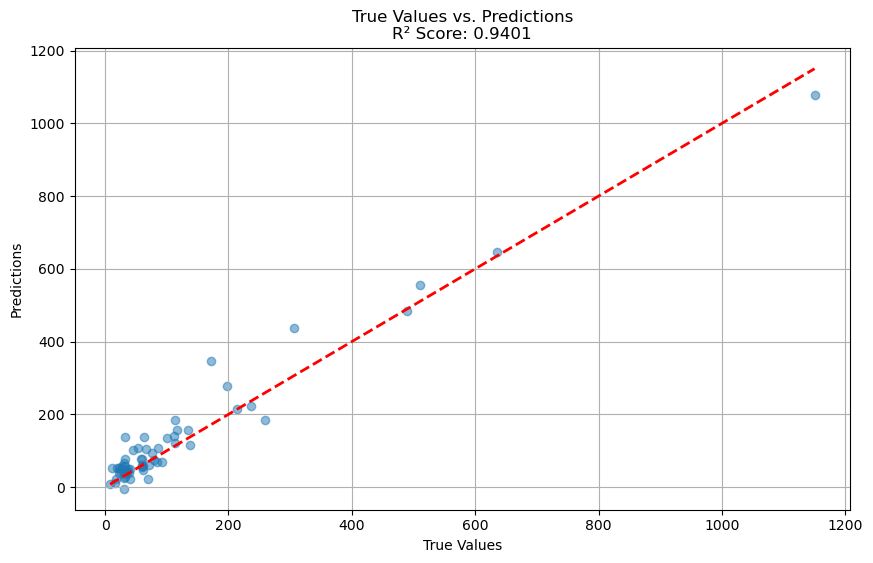

In [18]:
from sklearn.metrics import r2_score

# Make predictions using the test data
Y_test_pred_sc = model.predict(X_test_sc)

Y_test_pred =  target_scaler.inverse_transform(Y_test_pred_sc)

r2 = r2_score(Y_test, Y_test_pred)

# Plot true values vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(Y_test, Y_test_pred, alpha=0.5)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title(f'True Values vs. Predictions\nR² Score: {r2:.4f}')

# Add a 45-degree line for reference
plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], 'r--', lw=2)

plt.grid(True)
plt.show()


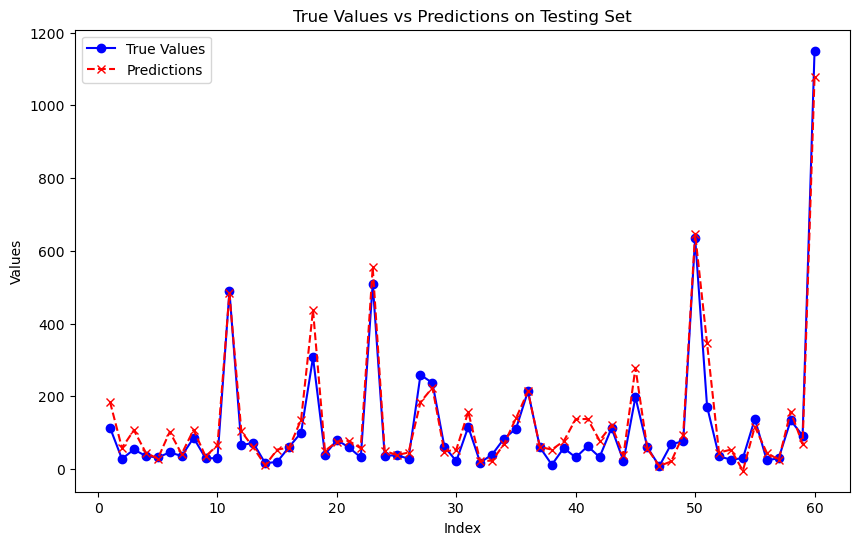

In [19]:
# Assuming 'results' DataFrame is already created as shown in your code
# and contains both 'True Values' and 'Predictions' columns

plt.figure(figsize=(10, 6))

index = np.arange(1, len(Y_test) + 1)

# Plot true values
plt.plot(index, Y_test, label='True Values', marker='o', linestyle='-', color='blue')

# Plot predictions
plt.plot(index, Y_test_pred, label='Predictions', marker='x', linestyle='--', color='red')

# Add labels and title
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('True Values vs Predictions on Testing Set')

# Show legend
plt.legend()

# Show the plot
plt.show()